<a href="https://colab.research.google.com/github/theoberk25/class-02-html-practice/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q geopandas networkx

In [3]:
%config InlineBackend.figure_formats = ["svg"]
import base64
import io
import json
import requests

import pandas as pd; pd.set_option('display.max_rows', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

from shapely import Point

# Week 5: Graphs, flows, and arms

### Fetching SIPRI flow data

This is a case study in real-world data munging.  There is extensive pre-processing to do to make the data useable.  We've chosen to show it to you in this notebook so that you get a realistic sense of the data challenges of working with a new dataset by reading through the notebook.  (Of course, you can also just click through it and everything should work.)

We're going to be working with a dataset from SIPRI (the Stockholm International Peace Research Institute) that tracks how arms and weaponry move around the world.

They have created a unit of weaponry called TIV ("trend indicator value"), which is an attempt to measure comparable amounts of **military capability**. It's some mix of cost and lethality that is designed to make it possible to compare arms flows across type and time.

For more on TIV, see the SIPRI fact sheet ["Measuring International Arms Transfers"](https://www.sipri.org/sites/default/files/files/FS/SIPRIFS1212.pdf).

SIPRI doesn't intend for users to grab their full dataset all at once, but we've figured out how to pull the whole CSV without any filters.  This might take a minute or more to run.  If it times out, try it again!

In [4]:
raw_data = requests.post(
    "https://atbackend.sipri.org/api/p/trades/trade-register-csv/",
    json={"filters": []},
).json()

Next, it turns out to be encoded in base 64, and we have to convert it to a more standard format.  Base 64 is a pretty nonstandard format, often used because it can encompass special characters, so it's important to notice the need to translate it or subsequent manipulations won't work as expected.

When you run the next cell, we'll examine the first 15 lines of the decoded file, which turns out to be a text header that needs to be chopped off the CSV for the rest of our work.  So we split at the carriage return (`split("\n")`) before continuing.

In [5]:
csv_lines = base64.b64decode(raw_data["bytes"]).decode("iso-8859-1").split("\n")
csv_lines[:15]

["Transfers of major conventional arms from All countries  to All countries . Deals with deliveries made for the year range 'Not specified' to 'Not specified' ",
 "A '?' in a column indicates uncertain data. The 'Number delivered' and the 'Year(s) of deliveries' refer only to deliveries in the selected year(s).",
 "An empty field for 'Number ordered' indicates that data is not yet available.",
 'SIPRI trend-indicator values (TIVs) are in millions.',
 "An empty field for 'SIPRI TIV for total order' indicates that data (on the number ordered and/or the TIV per unit) is not available.",
 "A '0' for 'SIPRI TIV of delivered weapons' indicates that the volume of deliveries is between 0 and 0.5 million SIPRI TIV; and an empty field indicates that no deliveries have been identified.",
 'Figures may not add up to stated totals due to the conventions of rounding.',
 'For the method used for the SIPRI TIV and explanations of the conventions; abbreviations and acronyms see <https://www.sipri.org/d

In [6]:
first_line_index = next(idx for idx, line in enumerate(csv_lines) if line.startswith("Recipient,"))
first_line_index

11

Let's make the dataframe!  It's got a huge amount of information about the weapons, when ordered, whether new or second-hand, and comments about the conflict context.

In [7]:
arms_df = pd.read_csv(io.StringIO("\n".join(csv_lines[first_line_index:])))
arms_df.to_csv("fulldata.csv")
arms_df

,Recipient,Supplier,Year of order,,Number ordered,.1,Weapon designation,Weapon description,Number delivered,.2,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons
0,Afghanistan,Brazil,2017.0,NaN,6.0,NaN,EMB-314 Super Tucano,trainer/combat aircraft,6.0,?,2018,New,A-29B version; financed by USA; ordered via US...,4.50,27.0,27.0
1,Afghanistan,Russia,2004.0,NaN,6.0,NaN,aircraft engine,aircraft engine,6.0,NaN,2005,New,Klimov TV-3-117 turboshaft; spare engines for ...,0.50,3.0,3.0
2,Afghanistan,Soviet Union,1977.0,?,26.0,NaN,AI-25,turbofan,26.0,?,1977; 1978,New,For 26 L-39 trainer aircraft from Czechoslovak...,0.60,15.6,15.6
3,Afghanistan,Soviet Union,1988.0,?,2300.0,?,R-17 Elbrus,SSM,2300.0,?,1988; 1989; 1990; 1991,New,Mainly for use against Mujahideen rebel forces,1.25,2875.0,2875.0
4,Afghanistan,United Kingdom,2009.0,NaN,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,2010,Second hand,Second-hand Mi-17 version bought by UK for 'Pr...,2.90,5.8,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29053,Zimbabwe,Russia,1998.0,?,6.0,NaN,Mi-24P/Mi-35P,combat helicopter,6.0,NaN,1999,Second hand,Second-hand; bought for use in DRC against reb...,3.60,21.6,21.6
29054,Zimbabwe,Italy,1967.0,?,20.0,?,Model-56 105mm,towed gun,20.0,?,1967,New,Supplier uncertain,0.45,9.0,9.0
29055,Zimbabwe,Soviet Union,1975.0,?,15.0,?,T-34-85,tank,15.0,?,1975,Second hand,Second-hand; supplier uncertain,0.38,5.7,5.7
29056,Zimbabwe,China,2004.0,?,5.0,?,Type-89/ZSD-89,APC,5.0,?,2004,New,ARV version,0.30,1.5,1.5


In [8]:
arms_df.groupby(["Recipient", "Supplier", "Year of order"]).count()

Number ordered   .1  \
Recipient            Supplier           Year of order                           
ANC (South Africa)*  Soviet Union       1988.0         0               1    1   
Afghanistan          Belarus            2018.0         0               1    0   
                     Bosnia-Herzegovina 2009.0         0               1    0   
                                        2012.0         1               1    1   
                     Brazil             2013.0         0               1    0   
...                                                   ..             ...  ...   
unknown recipient(s) United States      1995.0         0               1    0   
                                        2010.0         0               1    1   
                                        2013.0         0               1    1   
                                        2018.0         2               2    2   
                                        2023.0         1               1    0   

                                                       Weapon designation  \
Recipient            Supplier           Year of order                       
ANC (South Africa)*  Soviet Union       1988.0                          1   
Afghanistan          Belarus            2018.0                          1   
                     Bosnia-Herzegovina 2009.0                          1   
                                        2012.0                          1   
                     Brazil             2013.0                          1   
...                                                                   ...   
unknown recipient(s) United States      1995.0                          1   
                                        2010.0                          1   
                                        2013.0                          1   
                                        2018.0                          2   
                                        2023.0                          2   

                                                       Weapon description  \
Recipient            Supplier           Year of order                       
ANC (South Africa)*  Soviet Union       1988.0                          1   
Afghanistan          Belarus            2018.0                          1   
                     Bosnia-Herzegovina 2009.0                          1   
                                        2012.0                          1   
                     Brazil             2013.0                          1   
...                                                                   ...   
unknown recipient(s) United States      1995.0                          1   
                                        2010.0                          1   
                                        2013.0                          1   
                                        2018.0                          2   
                                        2023.0                          2   

                                                       Number delivered   .2  \
Recipient            Supplier           Year of order                          
ANC (South Africa)*  Soviet Union       1988.0                        1    1   
Afghanistan          Belarus            2018.0                        1    0   
                     Bosnia-Herzegovina 2009.0                        1    1   
                                        2012.0                        1    0   
                     Brazil             2013.0                        1    1   
...                                                                 ...  ...   
unknown recipient(s) United States      1995.0                        1    0   
                                        2010.0                        1    1   
                                        2013.0                        1    1   
                                        2018.0                        2    2   
                                        

We can narrow down what we're looking at.  The next cell lets you toggle between looking for (a) [Mi-17s](https://en.wikipedia.org/wiki/Mil_Mi-17) that do not come from Russia/USSR, or (b) second-hand weapons.  Try it both ways.

In [9]:
arms_df[(arms_df["Weapon designation"] == "Mi-17") & (arms_df["Supplier"] != "Russia") & (arms_df["Supplier"] != "Soviet Union")]
# arms_df[arms_df["status"] == "Second hand"]

,Recipient,Supplier,Year of order,,Number ordered,.1,Weapon designation,Weapon description,Number delivered,.2,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons
4,Afghanistan,United Kingdom,2009.0,NaN,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,2010,Second hand,Second-hand Mi-17 version bought by UK for 'Pr...,2.90,5.80,5.80
89,Afghanistan,unknown supplier(s),2007.0,?,6.0,NaN,Mi-17,transport helicopter,6.0,NaN,2008,Second hand,Probably second-hand; financed by UAE,2.90,17.40,17.40
91,Afghanistan,Slovakia,2007.0,NaN,3.0,?,Mi-17,transport helicopter,3.0,?,2008,Second hand,Second-hand; aid,2.90,8.70,8.70
94,Afghanistan,Czechia,2007.0,NaN,6.0,NaN,Mi-17,transport helicopter,6.0,NaN,2007; 2008,Second hand but modernized,Second-hand but modernized before delivery; ai...,4.79,28.71,28.71
153,African Union**,unknown supplier(s),2004.0,NaN,15.0,NaN,Mi-17,transport helicopter,15.0,?,2005,Second hand,Leased from and operated by civilian company f...,2.90,43.50,43.50
744,Angola,Czechia,2006.0,?,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,2007,Second hand,Second-hand; Mi-17 version,2.90,5.80,5.80
758,Angola,unknown supplier(s),1993.0,?,7.0,?,Mi-17,transport helicopter,7.0,?,1993,Second hand,Second-hand; supplier possibly Russia,2.90,20.30,20.30
3544,Cambodia,Ukraine,1994.0,?,4.0,?,Mi-17,transport helicopter,4.0,?,1994,Second hand,Second-hand; probably incl 2 Mi-8 and 2 Mi-17 ...,2.90,11.60,11.60
3664,Cambodia,Ukraine,1997.0,NaN,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,1997,Second hand,Second-hand; $1.3 m deal; probably illegally e...,2.90,5.80,5.80
4032,Canada,unknown supplier(s),2010.0,NaN,3.0,?,Mi-17,transport helicopter,3.0,?,2010,New,Possibly second-hand; lease for use in Afghani...,7.25,21.75,21.75


What other statuses are possible?

In [10]:
arms_df["status"].unique()

array(['New', 'Second hand', 'Second hand but modernized', nan],
      dtype=object)

In [11]:
arms_df["Weapon designation"].value_counts()

,count
Weapon designation,
aircraft engine,417
vehicle engine,398
ship engine,379
Mi-17,239
M-113,225
...,...
F-14A Tomcat,1
Kharg,1
Tigercat-2,1


# Mapping transfers


Visualizing the SIFRI dataset presents several problems:

* Recipients and suppliers are _usually_ countries, but this does not always hold. Notice that the dataset includes non-state actors (such as the [Houthi rebels](https://en.wikipedia.org/wiki/Houthis) or the [Mujahideen](https://en.wikipedia.org/wiki/Afghan_mujahideen)).  We will need one lat/long location per actor, so we'll try to find an appropriate capital city.
* This dataset goes back to the 1940s, so it references countries that no longer exist (such as [Biafra](https://en.wikipedia.org/wiki/Biafra) and [Yugoslavia](https://en.wikipedia.org/wiki/Yugoslavia)).
* There is some variability in names. For instance, "Ivory Coast" and "Cote d'Ivoire" are two different names for the same country.

For visualization purposes, we'll map these special cases to the nearest equivalent contemporary states. For instance, we'll map South Vietnam to Vietnam; Saigon (the former capital of South Vietnam) is now Ho Chi Minh City (the current capital of Vietnam). We'll exclude flows to or from entities that do not clearly correspond to a single region (for instance, the United Nations).

The following dictionary associating SIPRI states to modern states was made by hand and represents a lot of labor!  You should at least glance through it to get a sense of some of the nitty-gritty involved here.  Note the comments at the end about non-obvious decisions (a good practice when cleaning data, so you'll know what you were thinking later on!) and the explicit list of exceptions.

In [12]:
capitals_map = {
    "ANC (South Africa)*": "South Africa",
    "Anti-Castro rebels (Cuba)*": "Cuba",
    "Amal (Lebanon)*": "Lebanon",
    "Armas (Guatemala)*": "Guatemala",
    "Contras (Nicaragua)*": "Nicaragua",
    "Darfur rebels (Sudan)*": "Sudan",
    "ELF (Ethiopia)*": "Ethiopia",
    "EPLF (Ethiopia)*": "Ethiopia",
    "FRELIMO (Portugal)*": "Portugal",
    "Haiti rebels*": "Haiti",
    "Hezbollah (Lebanon)*": "Lebanon",
    "Houthi rebels (Yemen)*": "Yemen",
    "Indonesia rebels*": "Indonesia",
    "Khmer Rouge (Cambodia)*": "Cambodia",
    "Kurdistan Regional Government (Iraq)*": "Iraq",
    "LF (Lebanon)*": "Lebanon",
    "LRA (Uganda)*": "Uganda",
    "LTTE (Sri Lanka)*": "Sri Lanka",
    "Libya GNC": "Libya",
    "Libya HoR*": "Libya",
    "Congo": "Congo (Brazzaville)",
    "DR Congo": "Congo (Kinshasa)",
    "MNLF (Philippines)*": "Philippines",
    "MPLA (Portugal)*": "Portugal",
    "MTA (Myanmar)*": "Myanmar",
    "Micronesia": "Federated States of Micronesia",
    "Mujahedin (Afghanistan)*": "Afghanistan",
    "NLA (Macedonia)*": "North Macedonia",
    "NTC (Libya)*": "Libya",
    "Northern Alliance (Afghanistan)*": "Afghanistan",
    "Northern Cyprus": "Cyprus",
    "PAIGC (Portugal)*": "Portugal",
    "PIJ (Israel/Palestine)*": "Israel",
    "PKK (Turkiye)*": "Turkey",
    "PLO (Israel)*": "Israel",
    "PRC (Israel/Palestine)*": "Israel",
    "Pathet Lao (Laos)*": "Laos",
    "Provisional IRA (UK)*": "United Kingdom",
    "RPF (Rwanda)*": "Rwanda",
    "RUF (Sierra Leone)*": "United Kingdom",
    "SLA (Lebanon)*": "Lebanon",
    "SNA (Somalia)*": "Somalia",
    "SPLA (Sudan)*": "Sudan",
    "Southern rebels (Yemen)*": "Yemen",
    "Syria rebels*": "Syria",
    "Turkiye": "Turkey",
    "UAE": "United Arab Emirates",
    "UIC (Somalia)*": "Somalia",
    "UNITA (Angola)*": "Angola",
    "Ukraine Rebels*": "Ukraine",
    "United States": "United States of America",
    "United Wa State (Myanmar)*": "Myanmar",
    "Viet Minh (France)*": "France",
    "Viet Nam": "Vietnam",
    "ZAPU (Zimbabwe)*": "Zimbabwe",
    "GUNT (Chad)*": "Chad",
    "FAN (Chad)*": "Chad",
    "FMLN (El Salvador)*": "El Salvador",
    "Gambia": "The Gambia",
    "Lebanon Palestinian rebels*": "Lebanon",
    "Cote d'Ivoire": "Ivory Coast",
    "Bahamas": "The Bahamas",
    "FNLA (Angola)*": "Angola",
    "Cabo Verde": "Cape Verde",
    "Timor-Leste": "East Timor",
    "Saint Vincent": "Saint Vincent and the Grenadines",
    "Guinea-Bissau": "Guinea Bissau",
    "South Vietnam": "Vietnam",  # Saigon is now Ho Chi Minh City
    "Viet Cong (South Vietnam)*": "Vietnam",
    "Hamas (Palestine)*": "Palestine",
    "Soviet Union": "Russia",
    "NATO**": "Belgium",  # NATO headquarters in Brussels
    'European Union**': "Belgium",  # EU headquarters in Brussels
    "OSCE**": "Austria",  # secretariat in Vienna
    "Yemen Arab Republic (North Yemen)": "Yemen",  # same capital as Yemen (Sanaa)
    "North Yemen": "Yemen",  # same capital as Yemen (Sanaa)
    "Czechoslovakia": "Czechia",  # same capital as the modern Czech Republic (Prague)
    "Yugoslavia": "Serbia",  # same capital as Serbia (Belgrade)
    "East Germany (GDR)": "Germany",  # for large-scale flow maps, approximate East Berlin with Berlin
    "Western Sahara": "Morocco",  # largely under Moroccan occupation,
}

exclude_flows = {
    "nan",
    "unknown rebel group*",
    "unknown recipient(s)",
    'unknown supplier(s)',
    "United Nations**",
    "Regional Security System**",
    "African Union**",
    '0.25',
    '3',
}


Even more exceptions!  These lat/longs were added by hand.

In [13]:
# (long, lat) coordinates for capitals of entities not included in the places shapefile.
# Several of these entities are countries that no longer exist.
extra_capitals = {
    "Biafra": ("Enugu", 7.5139, 6.4483),  # 1967 capital (now part of Nigeria)
    "Bosnia-Herzegovina": ("Sarajevo", 18.4131, 43.8563),
    "South Yemen": ("Aden", 45.0176, 12.7906),
    "Katanga": ("Lubumbashi", 27.5026, -11.6876),
    "South Sudan": ("Juba",  31.5825, 4.8539),
    "Palestine": ("East Jerusalem", 35.217018, 31.771959),
    "Aruba": ("Oranjestad", -70.0353, 12.5227),
}

...and put into a format that's suitable for adding to the capitals list we're making.  Note the CRS (coordinate reference system) specified.

In [14]:
extra_capitals_gdf = gpd.GeoDataFrame(
    [
        {
            "adm0name": entity,
            "name": capital,
            "longitude": long,
            "latitude": lat,
            "geometry": Point(long, lat),
        }
        for entity, (capital, long, lat) in extra_capitals.items()
    ],
    crs="epsg:4326",
).set_index("adm0name")
extra_capitals_gdf

,name,longitude,latitude,geometry
adm0name,,,,
Biafra,Enugu,7.513900,6.448300,POINT (7.5139 6.4483)
Bosnia-Herzegovina,Sarajevo,18.413100,43.856300,POINT (18.4131 43.8563)
South Yemen,Aden,45.017600,12.790600,POINT (45.0176 12.7906)
Katanga,Lubumbashi,27.502600,-11.687600,POINT (27.5026 -11.6876)
South Sudan,Juba,31.582500,4.853900,POINT (31.5825 4.8539)
Palestine,East Jerusalem,35.217018,31.771959,POINT (35.21702 31.77196)
Aruba,Oranjestad,-70.035300,12.522700,POINT (-70.0353 12.5227)


Next we're going to read in a simple shapefile from a cartographic society that gives locations for major world cities and identifies which ones are capital cities.  Note even more special-case handling:  some countries have more than one capital!  (South Africa famously has three.)

In [15]:
places_gdf = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_populated_places_simple.zip")
capitals_gdf = places_gdf[places_gdf["adm0cap"] == 1].set_index("adm0name")
# force each nation to have exactly one capital
capitals_gdf = capitals_gdf[~capitals_gdf["name"].isin(["Sucre", "Yamoussoukro", "Bloemfontein", "Pretoria"])][["name", "latitude", "longitude", "geometry"]]
capitals_gdf = gpd.GeoDataFrame(pd.concat([capitals_gdf, extra_capitals_gdf]), crs="epsg:4326")

In [16]:
capitals_gdf.tail(100)

,name,latitude,longitude,geometry
adm0name,,,,
Albania,Tirana,41.327541,19.818883,POINT (19.81888 41.32754)
Armenia,Yerevan,40.183097,44.511606,POINT (44.51161 40.1831)
Azerbaijan,Baku,40.397218,49.860271,POINT (49.86027 40.39722)
Cambodia,Phnom Penh,11.551976,104.914689,POINT (104.91469 11.55198)
Bolivia,La Paz,-16.496028,-68.151931,POINT (-68.15193 -16.49603)
Benin,Cotonou,6.401954,2.518045,POINT (2.40435 6.36298)
Bulgaria,Sofia,42.685295,23.314708,POINT (23.31471 42.6853)
Belarus,Minsk,53.901923,27.564681,POINT (27.56468 53.90192)
Bhutan,Thimphu,27.472986,89.639014,POINT (89.63901 27.47299)


Hopefully this dataset gives you many ideas of things you could analyze.

Here are just a few...
* Study arms flows connected to a protracted conflict (e.g., Israel–Palestine)
* Pick a small window of time, like 1-2 years, and do a deeper look at that snapshot.
* The USSR collapsed circa 1991.  Do you see an immediate impact on arms flows?
* Consider second-hand arms sales.  How does weaponry "trickle down" from rich exporters to first and then second recipients.
* How does the popularity and regionality of a particular weapon (e.g., the Mi-17) change over time?

# Introduction to graphs

To make a visual that shows the movement, a natural data object is a **graph**, in the sense of discrete mathematics.  A graph is made up of vertices (also called nodes), with some of them connected by edges.  The edges can be weighted, and can have a direction.  So a flow can be represented as a weighted directed edge from vertex $v$ to vertex $w$.

We'll set this up with a dataframe giving only a limited number of attributes per state, then a secondary dataframe grouping by year.

In [17]:
flowmap_arms_df = arms_df[~arms_df["Supplier"].isin(exclude_flows) & ~arms_df["Recipient"].isin(exclude_flows)].rename(
    columns={
        "Year of order": "order_year",
        "Recipient": "recipient",
        "Supplier": "supplier",
        "SIPRI TIV for total order": "order_sipri_tiv"
    }
)
flowmap_arms_df["order_year"] = flowmap_arms_df["order_year"].astype(int)
flowmap_arms_df = flowmap_arms_df[flowmap_arms_df["order_year"] >= 1950]

In [18]:
orders_by_year_df = flowmap_arms_df.groupby(["order_year", "recipient", "supplier"]).sum()["order_sipri_tiv"]
orders_by_year_df

order_year  recipient  supplier      
1950        Argentina  United States     135.51
            Australia  United Kingdom    337.68
                       United States       0.60
            Belgium    United Kingdom     78.00
                       United States     756.12
                                          ...  
2023        Uruguay    Spain               0.00
                       United States      12.72
            Viet Nam   India              30.00
            Zambia     United States      20.80
            Zimbabwe   China              20.40
Name: order_sipri_tiv, Length: 15215, dtype: float64

## Example
Let's visualize arms flows to and from the U.S. in a particular year by constructing a graph.

In [19]:
year = 1980
country = "United States"

In [20]:
filtered_orders_df = orders_by_year_df[year].reset_index()
filtered_orders_df = filtered_orders_df[
    (filtered_orders_df["recipient"] == "United States")
    | (filtered_orders_df["supplier"] == "United States")
]
filtered_orders_df.head(10)

,recipient,supplier,order_sipri_tiv
13,Argentina,United States,46.55
17,Australia,United States,481.60
18,Austria,United States,105.00
21,Bangladesh,United States,14.80
25,Bolivia,United States,5.64
31,Brunei,United States,1.40
36,Canada,United States,4310.26
44,Chile,United States,52.85
49,Colombia,United States,42.92
52,Costa Rica,United States,0.44


We're going to use a basic graph library in Python called NetworkX.  We imported it above as `nx`.  Our graph will have directed edges FROM the supplier TO the recipient of an arms shipment.

In [21]:
orders_graph = nx.DiGraph()

for _, row in filtered_orders_df.iterrows():
    orders_graph.add_edge(
        row.supplier,
        row.recipient,
        weight=row.order_sipri_tiv,
    )

Where did the U.S. send arms that year?  (or receive from!)

In [22]:
orders_graph.edges

OutEdgeView([('United States', 'Argentina'), ('United States', 'Australia'), ('United States', 'Austria'), ('United States', 'Bangladesh'), ('United States', 'Bolivia'), ('United States', 'Brunei'), ('United States', 'Canada'), ('United States', 'Chile'), ('United States', 'Colombia'), ('United States', 'Costa Rica'), ('United States', 'Denmark'), ('United States', 'Dominican Republic'), ('United States', 'Ecuador'), ('United States', 'Egypt'), ('United States', 'El Salvador'), ('United States', 'Finland'), ('United States', 'Gabon'), ('United States', 'Germany'), ('United States', 'Greece'), ('United States', 'Guatemala'), ('United States', 'Honduras'), ('United States', 'Indonesia'), ('United States', 'Ireland'), ('United States', 'Israel'), ('United States', 'Italy'), ('United States', 'Jamaica'), ('United States', 'Japan'), ('United States', 'Jordan'), ('United States', 'Kenya'), ('United States', 'Malaysia'), ('United States', 'Mauritania'), ('United States', 'Morocco'), ('United 

Next we'll make a static map.  You can play around with thickness and color of the directed edges.

In [23]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

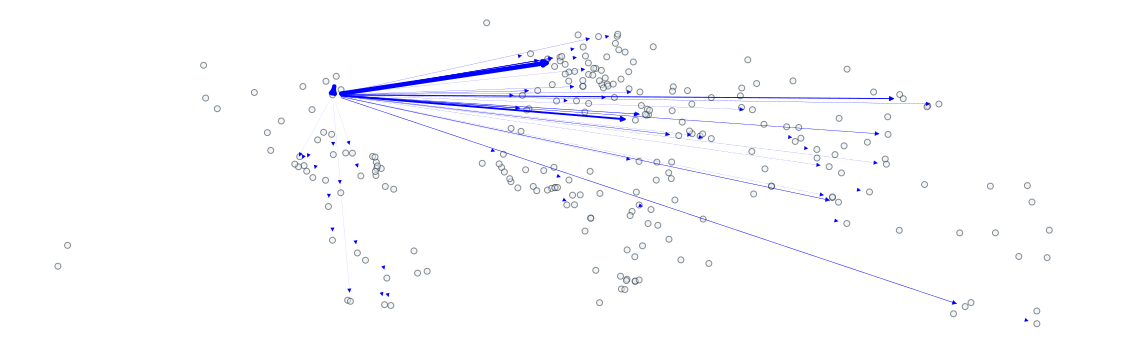

In [24]:
fig, ax = plt.subplots(figsize=(20, 40))
ax.axis("off")
places_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = dict(capitals_gdf.geometry)

for edge in orders_graph.edges(data='weight'):
    if edge[0] in exclude_flows or edge[1] in exclude_flows:
        continue

    edge_pos = {
        edge[0]: cast_point(pos[capitals_map.get(edge[0], edge[0])]),
        edge[1]: cast_point(pos[capitals_map.get(edge[1], edge[1])]),
    }
    nx.draw_networkx_edges(orders_graph, edge_pos, edgelist=[edge], width=0.001 * edge[2], ax=ax, edge_color="blue")

## Advanced flow visualizations with FlowmapBlue

Now we'll use a very cool package called FlowmapBlue to create beautiful and interactive flowmaps.

In [25]:
!pip install "git+https://github.com/PUBPOL-2130/notebooks#egg=pubpol2130&subdirectory=lib"

  Cloning https://github.com/PUBPOL-2130/notebooks to /tmp/pip-install-3ox3ilqm/pubpol2130_fd184e07312549d9b74e6891bf11bda0
  Running command git clone --filter=blob:none --quiet https://github.com/PUBPOL-2130/notebooks /tmp/pip-install-3ox3ilqm/pubpol2130_fd184e07312549d9b74e6891bf11bda0
  Resolved https://github.com/PUBPOL-2130/notebooks to commit e7cd653a09d9a8775bc30bd70d20c23dd65b7596
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
  Created wheel for pubpol2130: filename=pubpol2130-0.0.1-py3-none-any.whl size=3747 sha256=54f67d84753c65a0f7410108de1cc044a305a639e09787cb59becfc4c9e280e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-w96bf95w/wheels/de/36/19/875166503c3cbba368f467c40c5c908e90c21dca2f0b11f71e
Successfully built pubpol2130
  Attempting uni

This line will pop up a dialog asking for permission to generate Google Sheets credentials using your Google login.  If you're doing this in Colab, it should be particularly seamless.

In [26]:
from pubpol2130 import google_sheets_credentials, generate_flow_sheet

In [27]:
flowmap_locations_df = pd.DataFrame(
    [
        {
            "id": loc,
            "name": loc,
            "lat": capitals_gdf.loc[capitals_map.get(loc, loc), "latitude"],
            "lon": capitals_gdf.loc[capitals_map.get(loc, loc), "longitude"],
        }
        for loc in set(flowmap_arms_df["supplier"]) | set(flowmap_arms_df["recipient"])
    ]
)
flowmap_locations_df.head(5)

,id,name,lat,lon
0,Khmer Rouge (Cambodia)*,Khmer Rouge (Cambodia)*,11.551976,104.914689
1,Greece,Greece,37.985272,23.731375
2,South Sudan,South Sudan,4.853900,31.582500
3,NATO**,NATO**,50.835263,4.331371
4,DR Congo,DR Congo,-4.327778,15.313026


If you don't want to go through the whole Google permissions thing, read this [Medium article](https://medium.com/@a.marenkov/how-to-get-credentials-for-google-sheets-456b7e88c430) for info about getting credentials.

In [28]:
sheet_creds = google_sheets_credentials()

In [29]:
flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=flowmap_locations_df,
    created_by_name="Theo Berk",  # YOUR NAME HERE
    created_by_email="tb547@cornell.edu", # YOUR EMAIL HERE
    data_source_name="SIPRI Arms Transfers Database",
    data_source_url="https://www.sipri.org/databases/armstransfers",
    incoming_tooltip="Inbound arms transfers (TIV)",
    outgoing_tooltip="Outbound arms transfers (TIV)",
    flow_tooltip="Arms transfer (TIV)",
    total_unit="TIVs",
    sheet_title="PUBPOL 2130: SIPRI arms transfers (orders over time)",
    flow_title="SIPRI Arms Transfers Database: orders over time",
    flows={
        f"Year: {year}": year_df.reset_index().rename(columns={
            "supplier": "origin",
            "recipient": "dest",
            "order_sipri_tiv": "count",
        })
        for year, year_df in orders_by_year_df.groupby(level=0)
    }
)

 78%|███████▊  | 58/74 [02:23<00:39,  2.47s/it]


KeyboardInterrupt: 

In [ ]:
print(flow_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{flow_sheet.url.split('/')[-1]}")

#Homework 4, due Tuesday March 4, 1:25pm

Your homework this week starts with creating a flowmap.  Then you should (1) choose a question about arms flows, (2) read a SIPRI background paper connected to that topic, and (3) make a data product (typically a plot, like in previous weeks) to illustrate a key fact of your choice.

To access SIPRI's background papers, go to their [publications page](https://www.sipri.org/publications) and put "SIPRI background papers" in the publication type, and use the keyword to get closer to your topic.  (Note that most of these are regional rather than related to particular weapons.)

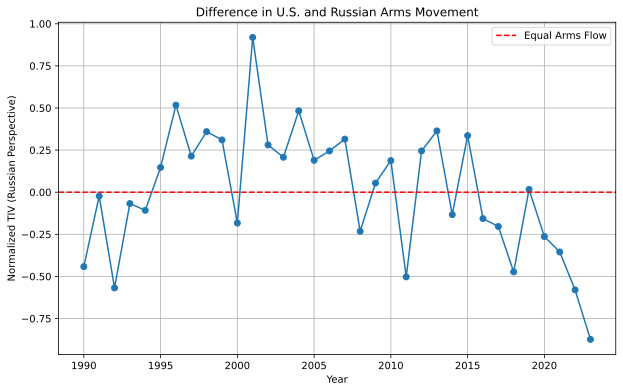

In [34]:
test_df = orders_by_year_df.reset_index()

russian_outgoing = test_df[((test_df["supplier"] == "Russia")
& (test_df["order_year"] >= 1990) & (test_df["order_year"] <= 2024))]

american_outgoing = test_df[((test_df["supplier"] == "United States")
& (test_df["order_year"] >= 1990) & (test_df["order_year"] <= 2024))]

russian_final = russian_outgoing.groupby(["order_year"])[["order_sipri_tiv"]].sum()

american_final = american_outgoing.groupby(["order_year"])[["order_sipri_tiv"]].sum()

def min_max_normalize(df):
    df['normalized_tiv'] = (df['order_sipri_tiv'] - df['order_sipri_tiv'].min()) / (df['order_sipri_tiv'].max() - df['order_sipri_tiv'].min())
    return df

russian_yearly_normalized = min_max_normalize(russian_final)
american_yearly_normalized = min_max_normalize(american_final)

final = pd.concat([russian_yearly_normalized, american_yearly_normalized], axis=1)

final = final.drop(['order_sipri_tiv', 'order_sipri_tiv'], axis=1)

final.columns = ["Russian", "American"]

final['Comparison'] = final['Russian'] - final['American']

plt.figure(figsize=(10, 6))
plt.plot(final['Comparison'], marker='o')
plt.title("Difference in U.S. and Russian Arms Movement")
plt.xlabel("Year")
plt.ylabel("Normalized TIV (Russian Perspective)")
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--', label='Equal Arms Flow')

# Add legend
plt.legend()

plt.savefig("2130_HW4.png")
plt.show()

In [ ]:
test_df = orders_by_year_df.reset_index()


In [ ]:
trial_df = test_df[(test_df["recipient"] == "Ukraine") & (test_df["supplier"] == "United States")
& (test_df["order_year"] >= 1976) & (test_df["order_year"] <= 1981)]

print(trial_df)